In [1]:
#Mandatory imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
train = pd.read_json("input/train.json")
target_train=train['is_iceberg']
test = pd.read_json("input/test.json")

In [3]:
target_train=train['is_iceberg']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
train['inc_angle']=train['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
X_test_angle=test['inc_angle']

In [4]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_3=(X_band_1+X_band_2)/2
#X_band_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in train["inc_angle"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis]
                          , X_band_2[:, :, :, np.newaxis]
                         , X_band_3[:, :, :, np.newaxis]], axis=-1)

In [5]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_band_test_3=(X_band_test_1+X_band_test_2)/2
#X_band_test_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in test["inc_angle"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

In [6]:
#Import Keras.
from matplotlib import pyplot
from keras.optimizers import RMSprop
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [7]:
#Data Aug for multi-input
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 10)

In [8]:
# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

In [9]:
# Finally create generator
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=10, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

In [10]:
def getVggAngleModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    x = base_model.get_layer('block5_pool').output
    

    x = GlobalMaxPooling2D()(x)
    merge_one = concatenate([x, angle_layer])
    merge_one = Dense(512, activation='relu', name='fc2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    merge_one = Dense(512, activation='relu', name='fc3')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(1, activation='sigmoid')(merge_one)
    
    model = Model(inputs=[base_model.input, input_2], outputs=predictions)
    
    adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1.0, decay=1e-6, amsgrad=True)
    model.compile(loss='binary_crossentropy',
                    optimizer=adam,
                    metrics=['accuracy'])
    
#     sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
#     model.compile(loss='binary_crossentropy',
#                   optimizer=sgd,
#                   metrics=['accuracy'])
    return model



In [11]:
#def myAngleCV(X_train, X_angle, X_test):
K=10
folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train, target_train))
y_test_pred_log = 0
y_train_pred_log=0
y_valid_pred_log = 0.0*target_train
for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = target_train[train_idx]
    X_holdout = X_train[test_idx]
    Y_holdout= target_train[test_idx]
    
    #Angle
    X_angle_cv=X_angle[train_idx]
    X_angle_hold=X_angle[test_idx]
    #define file path and get callbacks
    file_path = "%s_aug_model_weights.hdf5"%j
    callbacks = get_callbacks(filepath=file_path, patience=5)
    gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
    galaxyModel= getVggAngleModel()
    histr = galaxyModel.fit_generator(
            gen_flow,
            steps_per_epoch=24,
            epochs=100,
            shuffle=True,
            verbose=1,
            validation_data=([X_holdout,X_angle_hold], Y_holdout),
            callbacks=callbacks)
     #Getting the Best Model
    galaxyModel.load_weights(filepath=file_path)
    #Getting Training Score
    score = galaxyModel.evaluate([X_train_cv,X_angle_cv], y_train_cv, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    #Getting Test Score
    score = galaxyModel.evaluate([X_holdout,X_angle_hold], Y_holdout, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    #Getting validation Score.
    pred_valid=galaxyModel.predict([X_holdout,X_angle_hold])
    y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

    #Getting Test Scores
    temp_test=galaxyModel.predict([X_test, X_test_angle])
    y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

    #Getting Train Scores
    temp_train=galaxyModel.predict([X_train, X_angle])
    y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

y_test_pred_log=y_test_pred_log/K
y_train_pred_log=y_train_pred_log/K

print('\n Train Log Loss Validation= ',log_loss(target_train, y_train_pred_log))
print(' Test Log Loss Validation= ',log_loss(target_train, y_valid_pred_log))
#return y_test_pred_log


===================FOLD= 0
Epoch 1/100
24/24 [==============================] - 19s 790ms/step - loss: 1.1837 - acc: 0.5066 - val_loss: 0.6445 - val_acc: 0.6481
Epoch 2/100
24/24 [==============================] - 14s 578ms/step - loss: 1.0665 - acc: 0.5131 - val_loss: 0.6004 - val_acc: 0.7099
Epoch 3/100
24/24 [==============================] - 14s 583ms/step - loss: 1.0049 - acc: 0.5509 - val_loss: 0.5630 - val_acc: 0.7037
Epoch 4/100
24/24 [==============================] - 14s 585ms/step - loss: 0.9712 - acc: 0.5681 - val_loss: 0.5106 - val_acc: 0.7407
Epoch 5/100
24/24 [==============================] - 14s 585ms/step - loss: 0.9068 - acc: 0.5980 - val_loss: 0.4565 - val_acc: 0.7778
Epoch 6/100
24/24 [==============================] - 14s 588ms/step - loss: 0.8624 - acc: 0.6170 - val_loss: 0.4399 - val_acc: 0.7778
Epoch 7/100
24/24 [==============================] - 14s 590ms/step - loss: 0.7697 - acc: 0.6585 - val_loss: 0.3931 - val_acc: 0.7901
Epoch 8/100
24/24 [===============

Epoch 49/100
24/24 [==============================] - 12s 508ms/step - loss: 0.2253 - acc: 0.9048 - val_loss: 0.2075 - val_acc: 0.9006
Epoch 50/100
24/24 [==============================] - 12s 509ms/step - loss: 0.2274 - acc: 0.9111 - val_loss: 0.2066 - val_acc: 0.9006
Epoch 51/100
24/24 [==============================] - 14s 590ms/step - loss: 0.2255 - acc: 0.8989 - val_loss: 0.2037 - val_acc: 0.9068
Epoch 52/100
24/24 [==============================] - 12s 510ms/step - loss: 0.2278 - acc: 0.9010 - val_loss: 0.2147 - val_acc: 0.8944
Epoch 53/100
24/24 [==============================] - 14s 591ms/step - loss: 0.2300 - acc: 0.9027 - val_loss: 0.1995 - val_acc: 0.9068
Epoch 54/100
24/24 [==============================] - 14s 589ms/step - loss: 0.2239 - acc: 0.9158 - val_loss: 0.1853 - val_acc: 0.9255
Epoch 55/100
24/24 [==============================] - 12s 509ms/step - loss: 0.2115 - acc: 0.9096 - val_loss: 0.2043 - val_acc: 0.9006
Epoch 56/100
24/24 [==============================] - 1

Epoch 45/100
24/24 [==============================] - 14s 589ms/step - loss: 0.2378 - acc: 0.9064 - val_loss: 0.1990 - val_acc: 0.9317
Epoch 46/100
24/24 [==============================] - 12s 502ms/step - loss: 0.2277 - acc: 0.9085 - val_loss: 0.2038 - val_acc: 0.9317
Epoch 47/100
24/24 [==============================] - 12s 508ms/step - loss: 0.2472 - acc: 0.8959 - val_loss: 0.2011 - val_acc: 0.9317
Epoch 48/100
24/24 [==============================] - 14s 589ms/step - loss: 0.2411 - acc: 0.8990 - val_loss: 0.1978 - val_acc: 0.9317
Epoch 49/100
24/24 [==============================] - 14s 592ms/step - loss: 0.2245 - acc: 0.9105 - val_loss: 0.1968 - val_acc: 0.9379
Epoch 50/100
24/24 [==============================] - 14s 588ms/step - loss: 0.2492 - acc: 0.8956 - val_loss: 0.1929 - val_acc: 0.9379
Epoch 51/100
24/24 [==============================] - 12s 512ms/step - loss: 0.2251 - acc: 0.9097 - val_loss: 0.1972 - val_acc: 0.9379
Epoch 52/100
24/24 [==============================] - 1

Epoch 35/100
24/24 [==============================] - 12s 508ms/step - loss: 0.2431 - acc: 0.8992 - val_loss: 0.2603 - val_acc: 0.8875
Epoch 36/100
24/24 [==============================] - 12s 510ms/step - loss: 0.2451 - acc: 0.8870 - val_loss: 0.2879 - val_acc: 0.8625
Epoch 37/100
24/24 [==============================] - 14s 590ms/step - loss: 0.2418 - acc: 0.8852 - val_loss: 0.2466 - val_acc: 0.8875
Epoch 38/100
24/24 [==============================] - 12s 508ms/step - loss: 0.2455 - acc: 0.9046 - val_loss: 0.2537 - val_acc: 0.9000
Epoch 39/100
24/24 [==============================] - 12s 508ms/step - loss: 0.2218 - acc: 0.9015 - val_loss: 0.2656 - val_acc: 0.8688
Epoch 40/100
24/24 [==============================] - 12s 510ms/step - loss: 0.2443 - acc: 0.8945 - val_loss: 0.2472 - val_acc: 0.8938
Epoch 41/100
24/24 [==============================] - 12s 510ms/step - loss: 0.2102 - acc: 0.9098 - val_loss: 0.2490 - val_acc: 0.9000
Epoch 42/100
24/24 [==============================] - 1

Epoch 48/100
24/24 [==============================] - 12s 510ms/step - loss: 0.2228 - acc: 0.8997 - val_loss: 0.1296 - val_acc: 0.9563
Epoch 49/100
24/24 [==============================] - 12s 510ms/step - loss: 0.2281 - acc: 0.8954 - val_loss: 0.2054 - val_acc: 0.9062
Epoch 50/100
24/24 [==============================] - 12s 508ms/step - loss: 0.2322 - acc: 0.9005 - val_loss: 0.1762 - val_acc: 0.9375
Epoch 51/100
24/24 [==============================] - 12s 509ms/step - loss: 0.2005 - acc: 0.9059 - val_loss: 0.1708 - val_acc: 0.9500
Train loss: 0.194840183549
Train accuracy: 0.916897506925
Test loss: 0.1282716766
Test accuracy: 0.9625

===================FOLD= 5
Epoch 1/100
24/24 [==============================] - 16s 677ms/step - loss: 1.6661 - acc: 0.4811 - val_loss: 0.7522 - val_acc: 0.5625
Epoch 2/100
24/24 [==============================] - 14s 590ms/step - loss: 1.0146 - acc: 0.5404 - val_loss: 0.6118 - val_acc: 0.7000
Epoch 3/100
24/24 [==============================] - 14s 590

Epoch 7/100
24/24 [==============================] - 14s 589ms/step - loss: 0.7023 - acc: 0.6273 - val_loss: 0.4858 - val_acc: 0.7438
Epoch 8/100
24/24 [==============================] - 14s 590ms/step - loss: 0.6373 - acc: 0.6648 - val_loss: 0.4821 - val_acc: 0.7250
Epoch 9/100
24/24 [==============================] - 14s 589ms/step - loss: 0.6171 - acc: 0.6904 - val_loss: 0.4637 - val_acc: 0.7562
Epoch 10/100
24/24 [==============================] - 14s 588ms/step - loss: 0.5604 - acc: 0.7194 - val_loss: 0.4356 - val_acc: 0.7562
Epoch 11/100
24/24 [==============================] - 14s 591ms/step - loss: 0.4944 - acc: 0.7560 - val_loss: 0.4267 - val_acc: 0.7812
Epoch 12/100
24/24 [==============================] - 12s 509ms/step - loss: 0.4956 - acc: 0.7537 - val_loss: 0.4291 - val_acc: 0.7937
Epoch 13/100
24/24 [==============================] - 12s 508ms/step - loss: 0.4460 - acc: 0.7863 - val_loss: 0.4535 - val_acc: 0.7875
Epoch 14/100
24/24 [==============================] - 12s 


===================FOLD= 7
Epoch 1/100
24/24 [==============================] - 17s 708ms/step - loss: 1.4887 - acc: 0.5182 - val_loss: 0.6854 - val_acc: 0.5375
Epoch 2/100
24/24 [==============================] - 14s 592ms/step - loss: 0.9897 - acc: 0.5340 - val_loss: 0.6770 - val_acc: 0.5687
Epoch 3/100
24/24 [==============================] - 14s 590ms/step - loss: 0.9920 - acc: 0.5300 - val_loss: 0.6257 - val_acc: 0.6250
Epoch 4/100
24/24 [==============================] - 14s 590ms/step - loss: 0.8763 - acc: 0.5852 - val_loss: 0.5750 - val_acc: 0.6562
Epoch 5/100
24/24 [==============================] - 14s 592ms/step - loss: 0.8043 - acc: 0.6016 - val_loss: 0.5400 - val_acc: 0.6750
Epoch 6/100
24/24 [==============================] - 14s 589ms/step - loss: 0.7098 - acc: 0.6528 - val_loss: 0.4770 - val_acc: 0.7125
Epoch 7/100
24/24 [==============================] - 14s 591ms/step - loss: 0.6627 - acc: 0.6756 - val_loss: 0.4000 - val_acc: 0.7937
Epoch 8/100
24/24 [===============

Train loss: 0.220631434151
Train accuracy: 0.906509695291
Test loss: 0.345455223322
Test accuracy: 0.84375

===================FOLD= 9
Epoch 1/100
24/24 [==============================] - 18s 730ms/step - loss: 1.0751 - acc: 0.5166 - val_loss: 0.6446 - val_acc: 0.5687
Epoch 2/100
24/24 [==============================] - 14s 589ms/step - loss: 0.9658 - acc: 0.5448 - val_loss: 0.5933 - val_acc: 0.6562
Epoch 3/100
24/24 [==============================] - 14s 588ms/step - loss: 0.8938 - acc: 0.5751 - val_loss: 0.5599 - val_acc: 0.7000
Epoch 4/100
24/24 [==============================] - 14s 590ms/step - loss: 0.8959 - acc: 0.5677 - val_loss: 0.5309 - val_acc: 0.7562
Epoch 5/100
24/24 [==============================] - 14s 590ms/step - loss: 0.8360 - acc: 0.5925 - val_loss: 0.5010 - val_acc: 0.7312
Epoch 6/100
24/24 [==============================] - 14s 593ms/step - loss: 0.7810 - acc: 0.6174 - val_loss: 0.4659 - val_acc: 0.7625
Epoch 7/100
24/24 [==============================] - 14s 589m

Epoch 61/100
24/24 [==============================] - 12s 510ms/step - loss: 0.2218 - acc: 0.9059 - val_loss: 0.2288 - val_acc: 0.9000
Epoch 62/100
24/24 [==============================] - 12s 510ms/step - loss: 0.2134 - acc: 0.9148 - val_loss: 0.2023 - val_acc: 0.9000
Epoch 63/100
24/24 [==============================] - 14s 590ms/step - loss: 0.2053 - acc: 0.9130 - val_loss: 0.1886 - val_acc: 0.9250
Epoch 64/100
24/24 [==============================] - 14s 589ms/step - loss: 0.1896 - acc: 0.9186 - val_loss: 0.1841 - val_acc: 0.9187
Epoch 65/100
24/24 [==============================] - 12s 509ms/step - loss: 0.2064 - acc: 0.9124 - val_loss: 0.1992 - val_acc: 0.9062
Epoch 66/100
24/24 [==============================] - 14s 590ms/step - loss: 0.2134 - acc: 0.9153 - val_loss: 0.1816 - val_acc: 0.9313
Epoch 67/100
24/24 [==============================] - 12s 510ms/step - loss: 0.2136 - acc: 0.9138 - val_loss: 0.1897 - val_acc: 0.9375
Epoch 68/100
24/24 [==============================] - 1

In [12]:
#preds=myAngleCV(X_train, X_angle, X_test)
preds = y_test_pred_log

In [13]:
# Submission to kaggle
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub_Adam_10folds_amsgrad_1e-3.csv', index=False)

dict_keys(['acc', 'val_loss', 'val_acc', 'loss'])


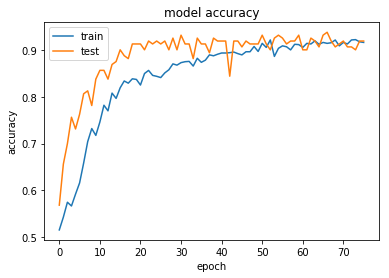

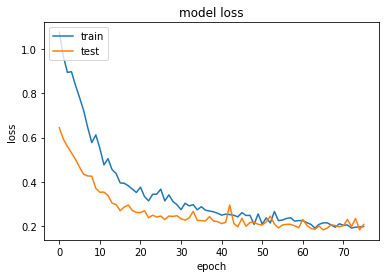

In [14]:
# list all data in history
print(histr.history.keys())
# summarize history for accuracy
plt.plot(histr.history['acc'])
plt.plot(histr.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histr.history['loss'])
plt.plot(histr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---

In [15]:
import matplotlib.image as mpimg

min1 = np.min(X_holdout)
max1 = np.max(X_holdout)
diff1 = max1 - min1
my_sum = lambda x: (x - min1)/diff1

X_holdout2 = my_sum(X_holdout)

In [16]:
Y_holdout

13      1
14      0
38      1
43      0
44      0
80      0
104     1
127     0
137     0
138     1
141     1
167     1
195     1
199     0
207     1
212     0
213     1
221     0
240     0
256     0
267     1
274     1
276     1
285     1
290     0
294     0
300     1
307     1
311     1
318     1
       ..
1363    1
1364    0
1373    1
1380    1
1394    0
1411    0
1435    0
1440    1
1445    1
1447    1
1460    1
1470    0
1488    0
1495    0
1504    1
1516    0
1525    0
1533    0
1537    0
1539    0
1541    0
1542    0
1549    0
1552    0
1559    0
1566    0
1567    0
1577    0
1590    0
1602    0
Name: is_iceberg, Length: 160, dtype: int64

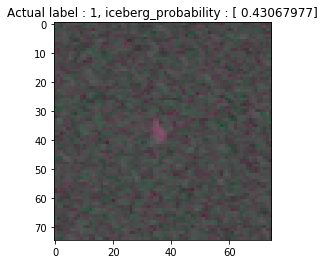

In [17]:
plt.imshow(X_holdout2[0], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[13])+ ","+" iceberg_probability : "+str(pred_valid[0])
plt.title(tl)

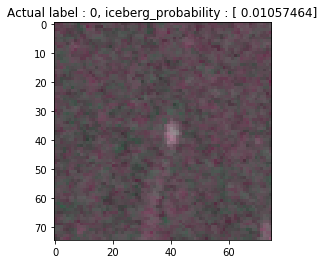

In [18]:
plt.imshow(X_holdout2[1], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[14])+ ","+" iceberg_probability : "+str(pred_valid[1])
plt.title(tl)

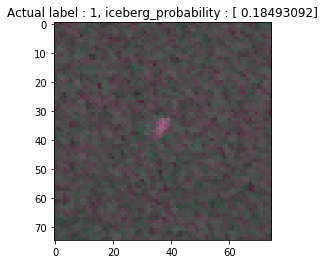

In [19]:
plt.imshow(X_holdout2[2], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[38])+ ","+" iceberg_probability : "+str(pred_valid[2])
plt.title(tl)

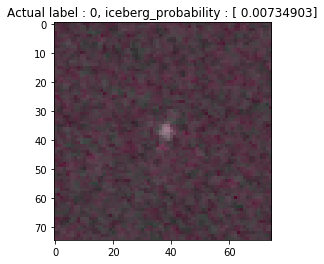

In [20]:
plt.imshow(X_holdout2[3], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[43])+ ","+" iceberg_probability : "+str(pred_valid[3])
plt.title(tl)

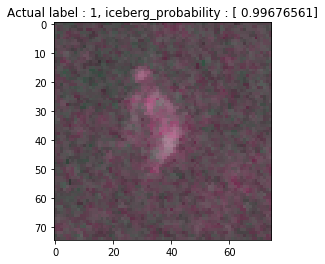

In [21]:
plt.imshow(X_holdout2[6], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[104])+ ","+" iceberg_probability : "+str(pred_valid[6])
plt.title(tl)

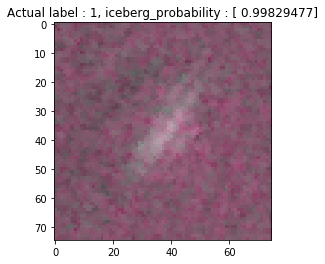

In [22]:
plt.imshow(X_holdout2[9], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[138])+ ","+" iceberg_probability : "+str(pred_valid[9])
plt.title(tl)

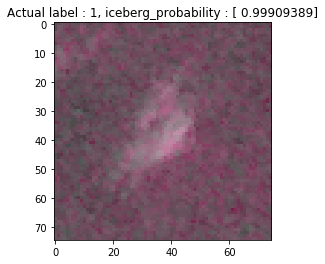

In [23]:
plt.imshow(X_holdout2[10], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[141])+ ","+" iceberg_probability : "+str(pred_valid[10])
plt.title(tl)

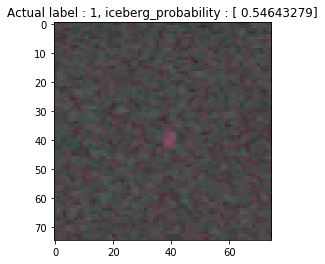

In [24]:
plt.imshow(X_holdout2[11], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[167])+ ","+" iceberg_probability : "+str(pred_valid[11])
plt.title(tl)

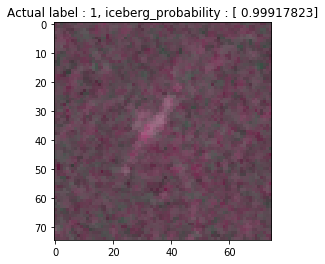

In [25]:
plt.imshow(X_holdout2[12], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[195])+ ","+" iceberg_probability : "+str(pred_valid[12])
plt.title(tl)

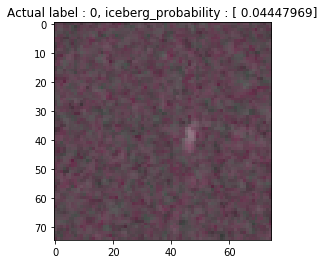

In [26]:
plt.imshow(X_holdout2[13], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[199])+ ","+" iceberg_probability : "+str(pred_valid[13])
plt.title(tl)

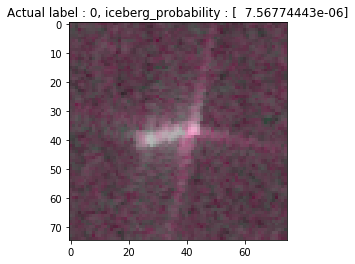

In [27]:
plt.imshow(X_holdout2[4], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[44])+ ","+" iceberg_probability : "+str(pred_valid[4])
plt.title(tl)